In [1]:
import qiskit
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

# Key operators

In [2]:
def init_source_op(qc, q, source):
    """Construct the source state from all 0's state"""
    for qbit, sbit in zip(q, source):
        if sbit:
            qc.x(qbit)

def a_op(qc, q):
    """Construct all equal superposition from initial (source) state"""
    list(map(qc.h, q))
    
def mcz_op(qc, controls, target):
    """Multi-controlled-Z operator"""
    return qc.mcu1(np.pi, controls, target)
    
def ss_op(qc, q, source):
    """Reflection about initial (source) state"""
    # flip qubits corresponding to a zero source bit
    for qbit, sbit in zip(q, source):
        if not sbit:
            qc.x(qbit)
    # multi-controlled-Z
    qc.mcu1(np.pi, q[:-1], q[-1])
    # flip qubits corresponding to a zero source bit
    for qbit, sbit in zip(q, source):
        if not sbit:
            qc.x(qbit)
    
def st_op(qc, q, target):
    """Reflection about target state (t)"""
    # flip qubits corresponding to a zero target bit
    for qbit, tbit in zip(q, target):
        if not tbit:
            qc.x(qbit)
    # multi-controlled-Z
    qc.mcu1(np.pi, q[:-1], q[-1])
    # flip qubits corresponding to a zero target bit
    for qbit, tbit in zip(q, target):
        if not tbit:
            qc.x(qbit)

def grover_op(qc, q, source, target):
    """Operator for one Grover iteration"""
    st_op(qc, q, target)
    a_op(qc, q)
    ss_op(qc, q, source)
    a_op(qc, q)

# Construct quantum circuit

In [3]:
# inputs
n = 5
source = [1, 1, 1, 1, 1]
target = [0, 1, 0, 1, 0]

# optimal iterations
niter = int(np.round(np.pi*np.sqrt(2**n)/4))
print("Optimal number of iterations = %s" % niter)

# quantum circuit
q = qiskit.QuantumRegister(n, name='q')
c = qiskit.ClassicalRegister(n, name='c')
qc = qiskit.QuantumCircuit(q, c, name='qc')

# initialize
# construct source
init_source_op(qc, q, source)
# construct equal superposition
a_op(qc, q)

# Grover iterations
for _ in range(niter):
    grover_op(qc, q, source, target)
    
# measurement
list(map(lambda x: qc.measure(*x), zip(q, c)))

print("------- operation counts (raw) -------")
for op, count in qc.count_ops().items():
    if op == 'measure':
        continue
    print("%s: %d" % (op, count))
    
print("------- operation counts (decomposed) -------")
for op, count in qc.decompose().count_ops().items():
    if op == 'measure':
        continue
    print("%s: %d" % (op, count))

# qc.draw()

Optimal number of iterations = 4
------- operation counts (raw) -------
h: 45
x: 29
mcu1: 8
------- operation counts (decomposed) -------
cu1: 120
cx: 112
u2: 45
u3: 29


# Qiskit simulation

In [4]:
# qasm simulator
backend = qiskit.BasicAer.get_backend('qasm_simulator')
job = qiskit.execute(qc, backend, shots=4096)
job.result().get_counts()

{'00110': 1, '01110': 1, '00111': 1, '01010': 4091, '11001': 1, '01111': 1}

In [5]:
# state vector simulator
backend = qiskit.BasicAer.get_backend('statevector_simulator')
qc.remove_final_measurements()
job = qiskit.execute(qc, backend)
job.result().get_statevector()

array([ 0.00513585+2.01817982e-16j, -0.00513585-1.79283858e-16j,
       -0.00513585-3.85323284e-17j,  0.00513585+1.74717937e-17j,
       -0.00513585-1.95220087e-16j,  0.00513585+1.58167691e-16j,
        0.00513585+1.85523931e-16j, -0.00513585-1.60393032e-16j,
       -0.00513585-1.56546695e-16j,  0.00513585+1.31661678e-16j,
       -0.99959107+4.22842098e-15j, -0.00513585-3.06979310e-17j,
        0.00513585+1.30095278e-16j, -0.00513585-1.89678090e-16j,
       -0.00513585-1.79626059e-16j,  0.00513585+1.69833800e-16j,
       -0.00513585-2.01071546e-16j,  0.00513585+1.98018498e-16j,
        0.00513585+1.14123338e-16j, -0.00513585-8.57442531e-17j,
        0.00513585+2.11572568e-16j, -0.00513585-1.82705472e-16j,
       -0.00513585-1.26509455e-16j,  0.00513585+6.12178920e-17j,
        0.00513585+2.02107383e-16j, -0.00513585-1.41123589e-16j,
       -0.00513585-2.12471118e-16j,  0.00513585+1.48845949e-16j,
       -0.00513585-1.44424712e-16j,  0.00513585+2.15813522e-16j,
        0.00513585+1.6861

In [6]:
backend = qiskit.BasicAer.get_backend('unitary_simulator')
qc.remove_final_measurements()
job = qiskit.execute(qc, backend)
job.result().get_unitary()

array([[ 0.00513585+2.01817982e-16j, -0.1502343 +1.66197394e-16j,
        -0.20331909+8.17573167e-16j, ..., -0.20331909+4.98735567e-16j,
        -0.1502343 +2.55965500e-16j, -0.1502343 +4.85696806e-17j],
       [-0.00513585-1.79283858e-16j, -0.20331909+4.91065620e-16j,
         0.20331909-7.30455245e-16j, ..., -0.1502343 +7.93498475e-17j,
         0.1502343 -2.15809002e-16j, -0.20331909+3.28405901e-16j],
       [-0.00513585-3.85323284e-17j,  0.1502343 -2.81928852e-16j,
        -0.1502343 +5.51354854e-16j, ...,  0.20331909-5.18069599e-16j,
        -0.20331909+6.31692619e-16j, -0.20331909+4.88476979e-16j],
       ...,
       [ 0.00513585+2.15813522e-16j,  0.20331909-3.62667060e-16j,
        -0.20331909+6.78000287e-16j, ..., -0.20331909+3.28734663e-16j,
         0.20331909-4.75935358e-16j, -0.1502343 -3.66924583e-17j],
       [ 0.00513585+1.68619679e-16j, -0.1502343 +1.88692287e-16j,
         0.1502343 -4.49169896e-16j, ...,  0.1502343 -2.53386425e-16j,
        -0.1502343 +3.61966103e-16j

# Analysis

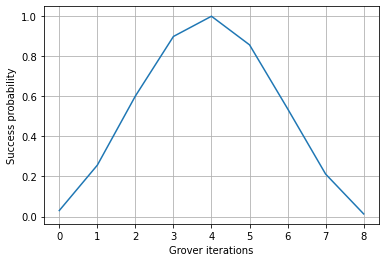

In [7]:
# success rate vs number of iterations

# inputs
n = 5
source = [1, 1, 1, 1, 1]
target = [0, 1, 0, 1, 0]

# simulation parameters
backend = qiskit.BasicAer.get_backend('qasm_simulator')
shots = 4096
niters = list(range(9))

# outputs
res = []

# iterate over number of Grover iterations
for r in niters:
    
    q = qiskit.QuantumRegister(n, name='q')
    c = qiskit.ClassicalRegister(n, name='c')
    qc = qiskit.QuantumCircuit(q, c, name='qc')
    
    # initialize
    # construct source
    init_source_op(qc, q, source)
    # construct equal superposition
    a_op(qc, q)
    
    # Grover iterations
    for _ in range(r):
        grover_op(qc, q, source, target)

    # measure
    list(map(lambda x: qc.measure(*x), zip(q, c)))

    job = qiskit.execute(qc, backend, shots=shots)
    counts = job.result().get_counts().get('01010', 0)
    res.append(counts)
    
# plot
plt.plot(niters, [c/shots for c in res])
plt.xlabel("Grover iterations")
plt.ylabel("Success probability")
plt.grid('on')